<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2021/blob/master/04_lab/lab4_trees_ensambling_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision trees, ensembling and model selection

![img](https://pbs.twimg.com/media/B13n2VVCIAA0hJS.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's generate a toy dataset:

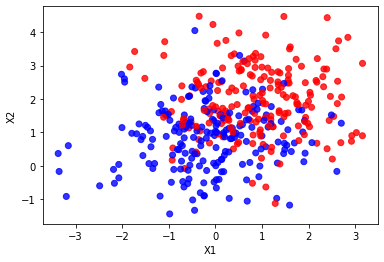

In [2]:
from sklearn.datasets import make_blobs

X_toy, y_toy = make_blobs(n_samples=400,
                          centers=[[0., 1.], [1., 2.]],
                          random_state=14)

plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.8, cmap='bwr')
plt.xlabel('X1'), plt.ylabel('X2');

## Decision trees out of the box

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

DecisionTreeClassifier has a number of parameters:
* `max_depth` – a limit on tree depth (default – no limit)
* `min_samples_split` – there should be at least this many samples to split further (default – 2)
* `min_samples_leaf` – there should be at least this many samples on one side of a split to consider it valid (default – 1).
* `criterion` – 'gini' or 'entropy' – split stuff over this parameter (default : gini)

In [4]:
clf = DecisionTreeClassifier(min_samples_leaf=15)
clf.fit(X_toy, y_toy)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Plot decision surface

Here's a function that makes a 2d decision boundary plot for a given classifier:

In [5]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  grid_step=0.02,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.arange(x_top_left[0], x_bottom_right[0], grid_step),
         np.arange(x_top_left[1], x_bottom_right[1], grid_step)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

Let's apply it to the tree we've fitted above:

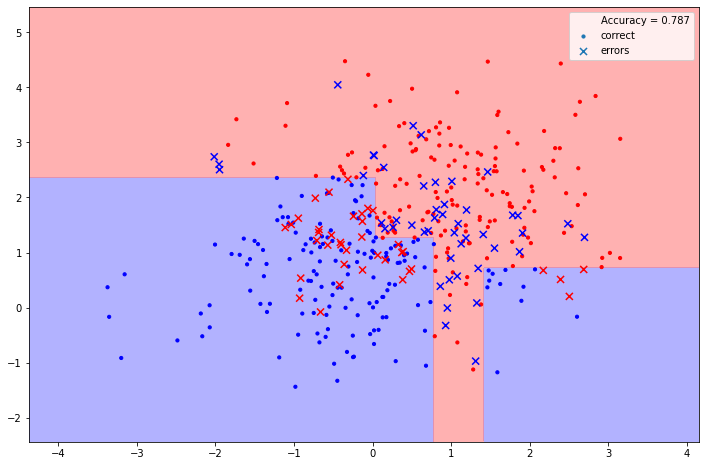

In [6]:
plt.figure(figsize=(12, 8))
plot_decision_surface(clf, X_toy, y_toy)

### Tree depth

First we are going to split our data to train and test subsets:

In [7]:
X_toy_train, X_toy_test, y_toy_train, y_toy_test = \
    train_test_split(X_toy, y_toy, test_size=0.25)

Now it's your turn to investigate how the decision boundary depends on the tree depth. Maximum tree depth is defined by the `max_depth` parameter. Try out the following values: `[1, 2, 3, 5, 10]`. Make decision boundary plots for both train and test datasets (separately).

  > *Hint: you can make a nice plot with multiple columns and rows (see example below).*
  
```python
plt.figure(figsize=(width, height))
for i in range(num_rows):
  for j in range(num_columns):
    plt.subplot(num_rows, num_columns, i * num_columns + j + 1)
    # subplot numbering starts from 1                       ^^^
    
    # ...
    # (do the plotting for plot i, j)
plt.show();
```

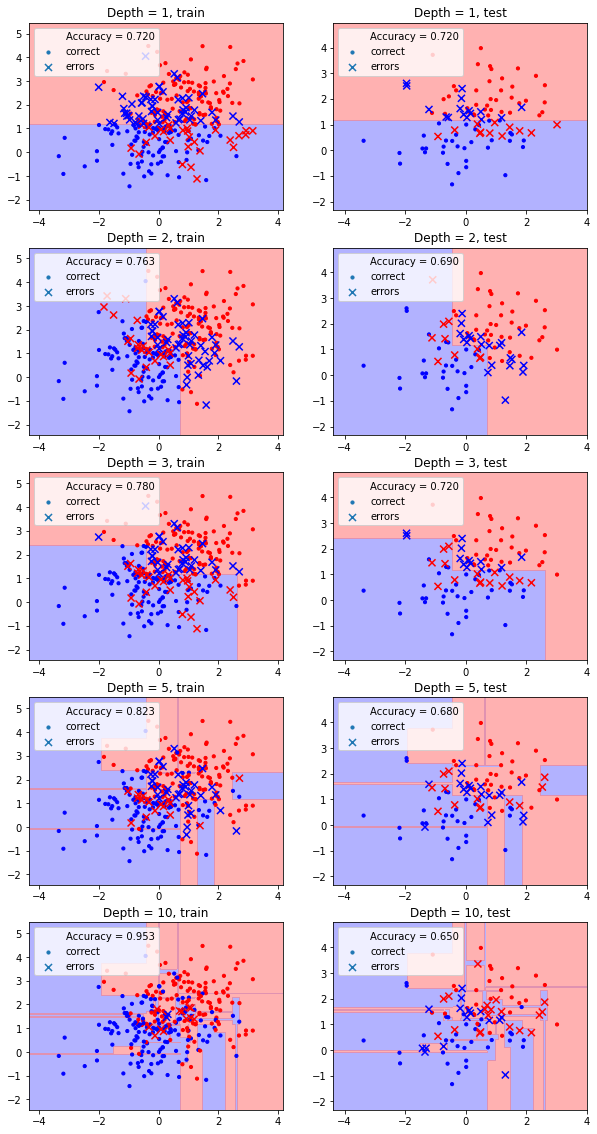

In [10]:
depth_values = [1, 2, 3, 5, 10]

plt.figure(figsize=(10, 20))

for i, depth in enumerate(depth_values):
  clf = DecisionTreeClassifier(max_depth=depth)
  clf.fit(X_toy_train, y_toy_train)

  plt.subplot(len(depth_values), 2, 2 * i + 1)
  plot_decision_surface(clf, X_toy_train, y_toy_train)
  plt.title(f"Depth = {depth}, train")

  plt.subplot(len(depth_values), 2, 2 * i + 2)
  plot_decision_surface(clf, X_toy_test, y_toy_test)
  plt.title(f"Depth = {depth}, test")
  

### Toy multiclass data

Now let's try out a multiclass classification case:

In [11]:
!wget https://github.com/yandexdataschool/MLatImperial2021/raw/master/04_lab/data.npz

--2021-01-29 14:38:51--  https://github.com/yandexdataschool/MLatImperial2021/raw/master/04_lab/data.npz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/MLatImperial2021/master/04_lab/data.npz [following]
--2021-01-29 14:38:51--  https://raw.githubusercontent.com/yandexdataschool/MLatImperial2021/master/04_lab/data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108474 (106K) [application/octet-stream]
Saving to: ‘data.npz’

data.npz            100%[===================>] 105.93K  --.-KB/s    in 0.02s   

2021-01-29 14:38:51 (4.16 MB/s) - ‘data.npz’ saved [108474/108474]



Firstly, we'll load the data:

In [12]:
data = np.load('data.npz')
X, y = data["X"], data["y"]

print(X.shape, y.shape)

(4505, 2) (4505,)


In [13]:
np.unique(y)

array([0, 1, 2, 3, 4])

And then split it to train and test:

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1337)

Now it's your turn to have a look at the data. Make a 2d scatter plot of the data points.

 > *Hint: instead of calling `scatter` separately for each class, you can give it a vector of color index values through the `c` parameter (`scatter(x0, x1, c=y, cmap='rainbow'`). The 'rainbow' colormap gives good enough color diversity for the multiclass case.*

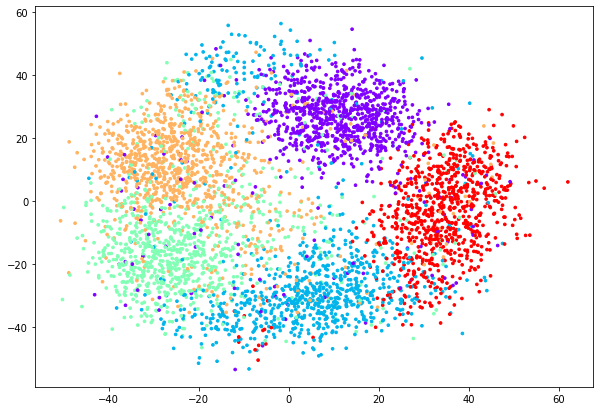

In [18]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=y, s=7, cmap='rainbow');

Now that we've had a look at the data, let's fit a decision tree on it:

In [19]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

and plot the result:

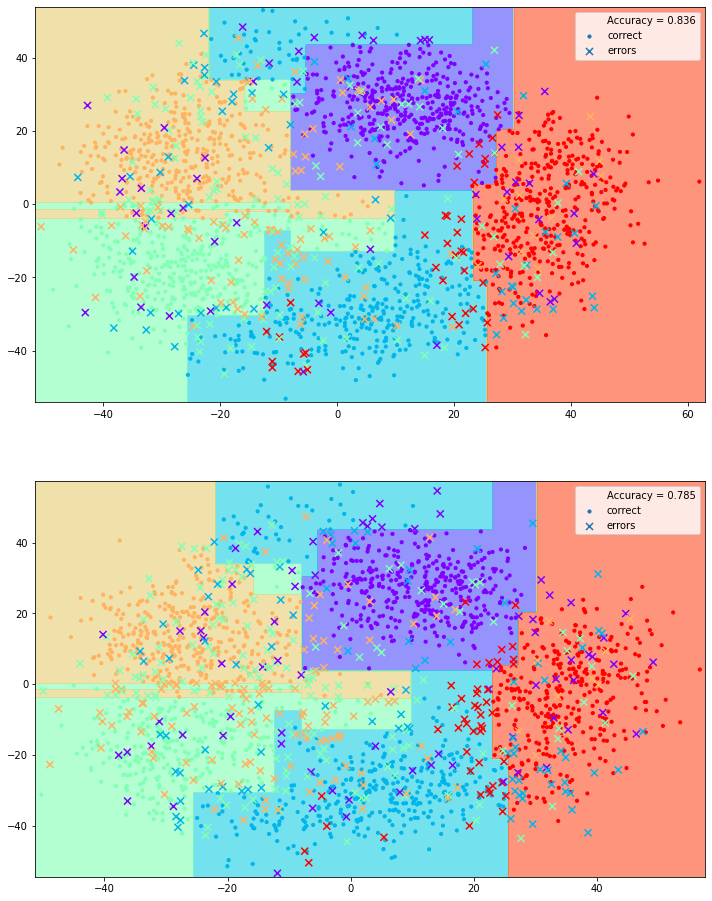

In [24]:
clf = DecisionTreeClassifier(min_samples_leaf=13)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow', grid_step=0.2)
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow', grid_step=0.2);

```

```

```

```

```

```

```

```

#### We need a better tree!

Try adjusting the parameters of DecisionTreeClassifier to improve the test accuracy.
 * Accuracy >= 0.72 - not bad for a start
 * Accuracy >= 0.75 - better, but not enough
 * Accuracy >= 0.77 - pretty good
 * Accuracy >= 0.78 - great! (probably the best result for a single tree)
 
Feel free to modify the DecisionTreeClassifier above instead of re-writing everything.

**Note:** some of the parameters you can tune are under the "Decision trees out of the box" header.

#### Bonus quest
Try adding feature transformations using a pipeline and a function transformer, e.g.:
```python
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    FunctionTransformer(lambda X: np.concatenate([X, X**2], axis=1)),
    DecisionTreeClassifier()
)
```

Which transformations should improve the score?

```
```
```
```

We've talked a lot about the importance of feature scaling. Why aren't we doing it here?

Try adding a standard scaler to the pipeline of your best model and check how it affects the result. Can you explain the result?

In [ ]:
<YOUR CODE>

```
```
```
```

## Ensembles

Let's build our own decision tree bagging and see how well it works. Implement the **`BagOfTrees`** class below:

In [27]:
class BagOfTrees:
  def __init__(self, n_estimators=10, **kwargs):
    self.trees = []
    for i in range(n_estimators):
        self.trees.append(DecisionTreeClassifier(**kwargs))
        
  def fit(self, X, y):
    trees = self.trees
    
    # Fit each of the trees on a random subset of X and y.
    # hint: you can select random subsample of data like this:
    # >>> ix = np.random.randint(0, len(X), len(X))
    # >>> X_sample, y_sample = X[ix], y[ix]

    for tree in trees:
      ix = np.random.randint(0, len(X), len(X))
      X_sample, y_sample = X[ix], y[ix]

      tree.fit(X_sample, y_sample)

    
  def predict(self, X):
    trees = self.trees
    
    # Compute predictions of each tree and aggregate them into
    # the ensemble prediction
    # Note: you can use tree.predict(X) to get the predicted classes
    # or tree.predict_proba(X) to get individual probabilities
    # for all classes

    probs = np.array([tree.predict_proba(X) for tree in trees])
    avg_probs = probs.mean(axis=0)
    return np.argmax(avg_probs, axis=1)

  
# once you think you're done, see if your code passes the asserts below

In [30]:
model = BagOfTrees(n_estimators=100, min_samples_leaf=3)
model.fit(X_train, y_train)

pred = model.predict(X_test[::100])
print("predictions:", pred)
assert isinstance(pred, np.ndarray), "prediction must be a numpy array"
assert str(pred.dtype).startswith('int'), "prediction dtype must be integer (int32/int64)"
assert pred.ndim == 1, "prediction must be a vector (1-dimensional)"
assert len(pred) == len(X_test[::100]), "must predict exactly one answer for each input (expected length %i, got %i)" % (len(X_test[::100]), len(pred))
assert any(model.trees[0].predict(X_train) != model.trees[1].predict(X_train)), "Some trees are identical. Did you forget to train each tree on a random part of the data?"

predictions: [0 3 0 0 0 1 2 3 4 3 0 3 2 0 2 1 1 0 1 3 1 2 2]


If the cell above executes without errors, run the code below to compare overall accuracy with individual tree accuracies:

In [31]:
for i, tree in enumerate(model.trees[:5]):
    print("tree {} individual accuracy = {:.5f}".format(
        i, accuracy_score(y_test, tree.predict(X_test))
      ))

print("Ensemble accuracy:",
      accuracy_score(y_test, model.predict(X_test))) # should be >= 0.78

tree 0 individual accuracy = 0.73768
tree 1 individual accuracy = 0.72659
tree 2 individual accuracy = 0.71682
tree 3 individual accuracy = 0.72126
tree 4 individual accuracy = 0.70972
Ensemble accuracy: 0.7842876165113183


And have a look at the decision surface:

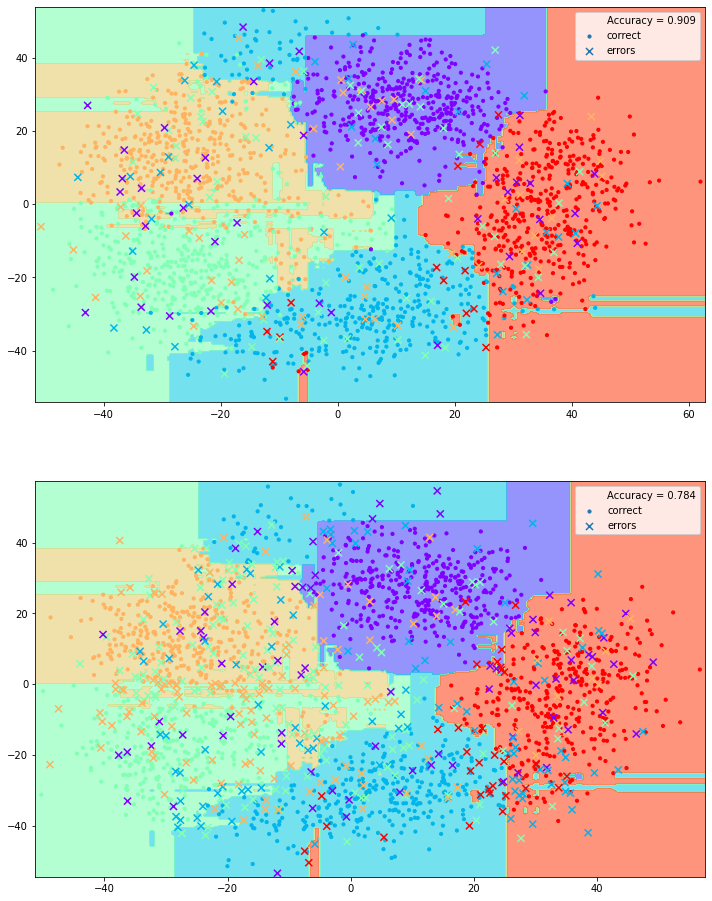

In [32]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(model, X_train, y_train, cmap='rainbow', grid_step=0.4)
plt.subplot(2, 1, 2)
plot_decision_surface(model, X_test, y_test, cmap='rainbow', grid_step=0.4);

Now let's check how train and test accuracy depends on the number of estimators.

Hint: instead of fitting a new BagOfTrees for each number of estimators we can just fit the maximum number and then iteratively predict and remove the fitted trees one by one.

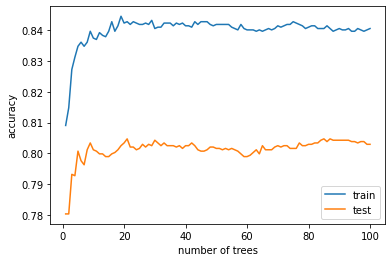

In [36]:
model = BagOfTrees(n_estimators=100, min_samples_split=30, splitter='random', random_state=42)
model.fit(X_train, y_train)

n_trees = []
test_score = []
train_score = []

while len(model.trees) > 0: # fill the lists above to make the plot
  n_trees.append(len(model.trees))
  train_score.append(accuracy_score(y_train, model.predict(X_train)))
  test_score.append(accuracy_score(y_test, model.predict(X_test)))
  model.trees.pop()

plt.plot(n_trees, train_score, label='train')
plt.plot(n_trees, test_score, label='test')
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('accuracy');

```
```
```
```
```
```

### Pre-implemented ensembles: Random Forest

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples, and the splits are chosen among subsets of features. Typically this leads to a slightly better performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Task: create and fit a random forest with
# 100 estimators and at least 5 samples per leaf

model = <YOUR CODE>

<YOUR CODE>

plt.figure(figsize=(12, 8))
plot_decision_surface(model, X_test, y_test, cmap='rainbow', grid_step=0.2)

```
```
```
```

### Pre-implemented ensembles: Gradient Boosting

Check out [this nice demo](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) on the gradient boosting.

Commonly used gradient boosting libraries:
 - [CatBoost](https://catboost.ai/)
 - [XGBoost](https://xgboost.ai/)
 - [LightGBM](https://lightgbm.readthedocs.io/en/latest/)

One of the most commonly used libraries for gradient boosing is the [XGBoost library](https://xgboost.ai/). Consider reading [this document](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) for an introduction to the algorithm.

Here's the [help page](https://xgboost.readthedocs.io/en/latest/parameter.html) listing available parameters.

In [37]:
!pip install xgboost --upgrade

     |████████████████████████████████| 157.5MB 82kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


Let's start by importing the classifier class and the function that plots individual trees as graphs:

In [38]:
from xgboost import XGBClassifier

We can now investigate how decision surface depends on the number of trees:

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  1


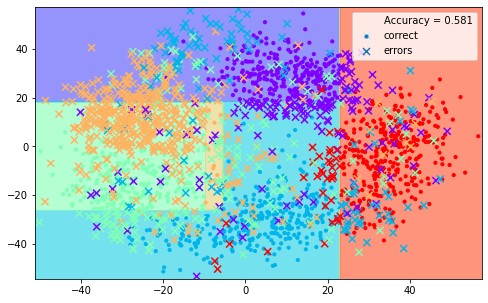

[15:51:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  2


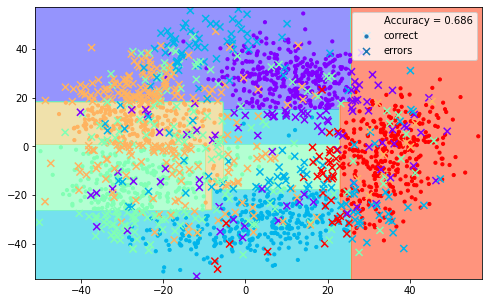

[15:51:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  3


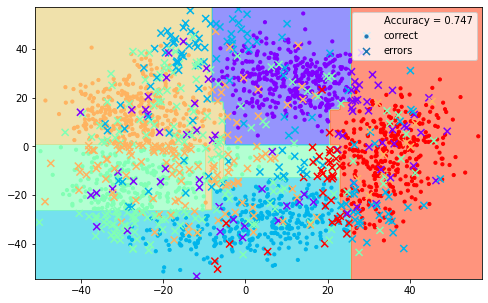

[15:51:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  4


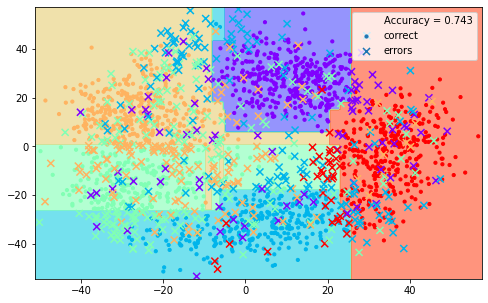

[15:51:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  5


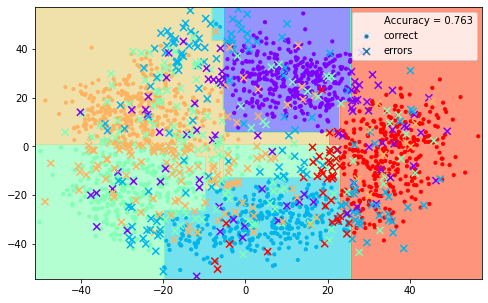

[15:51:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  6


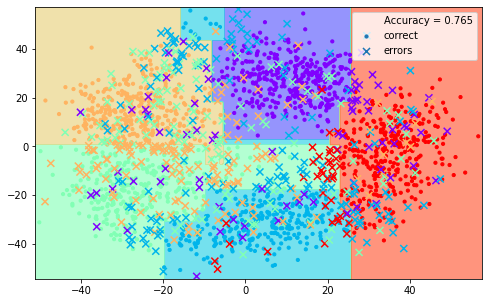

[15:51:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  7


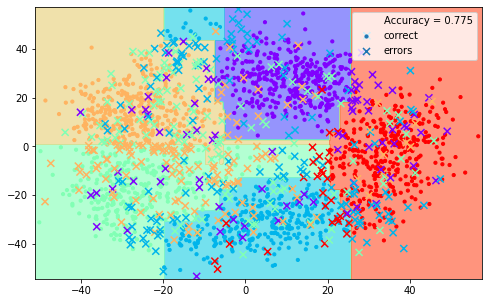

[15:51:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  8


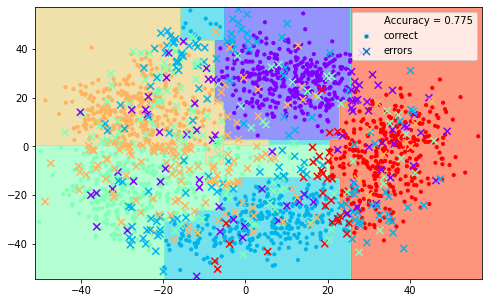

[15:51:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
n_estimators =  9


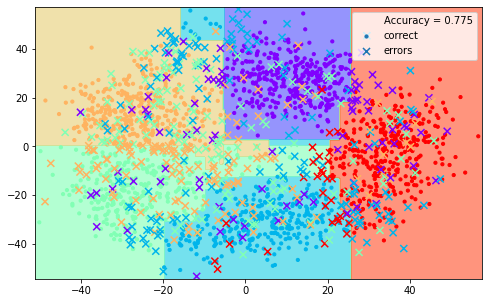

In [43]:
for n_estimators in range(1,10):
    model = XGBClassifier(n_estimators=n_estimators, max_depth=1,
                          learning_rate=0.5) # create an XGBClassifier with trees of depth 1,
                        # learning rate 0.5 and n_estimators estimators

    model.fit(X_train, y_train) # fit this model to the train data

    print("n_estimators = ", n_estimators)
    plt.figure(figsize=(8, 5))
    plot_decision_surface(model, X_test, y_test, cmap='rainbow', grid_step=0.4)
    plt.show()

<font color='red'>**Warning:**</font> current xgboost implementation is not very safe to typos, i.e. it can silently swallow whatever argument you provide, even if it has no effect, e.g.:

In [41]:
model = XGBClassifier(abrakadabra="I won't change anything")

so be sure to check your spelling.

Now let's try to improve the score by adjusting the parameters. Here are some of the parameters you may want to try:
  - `max_depth` – maximum tree depth,
  - `n_estimators` – number of trees (per class),
  - `learning_rate` – shrinkage,
  - `reg_lambda` – L2 regularization term on weights,
  - `subsample` – row random subsampling rate (per tree),
  - `colsample_bynode` – column subsampling rate (per node)
  - `gamma` – minimum loss reduction required to make a further partition on a leaf node of the tree

See [this page](https://xgboost.readthedocs.io/en/latest/parameter.html) for more information.

  > *Hint: since XGBClassifier has the same interface as sklearn models, you can use GridSearchCV on it if you want.* 

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


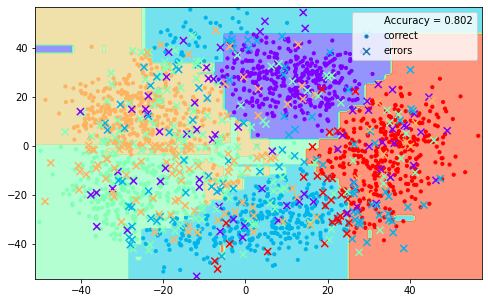

In [46]:
model = XGBClassifier(n_estimators=60, max_depth=5, learning_rate=0.05)

model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plot_decision_surface(model, X_test, y_test, cmap='rainbow', grid_step=0.8)
plt.show();

```
```
```
```

## Feature importance

For this example we are going to use California Housing Dataset.

The **target** variable is the median house value for California districts.


The features are:
 *   **MedInc** median income in block
 *   **HouseAge** median house age in block
 *   **AveRooms** average number of rooms
 *   **AveBedrms** average number of bedrooms
 *   **Population** block population
 *   **AveOccup** average house occupancy
 *   **Latitude** house block latitude
 *   **Longitude** house block longitude
 
 More information [here](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset).

In [47]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

In [48]:
dataset = fetch_california_housing()

`dataset` holds the data in numpy arrays, but we can convert it to a pandas dataframe:

In [55]:
data = pd.DataFrame(dataset.data, columns=dataset.feature_names).drop("MedInc", axis=1)
data['target'] = dataset.target

data.head(10)

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


Now, let's separate the features from the target and split the data to train and test parts:

In [56]:
data_X = data.drop('target', axis=1)
data_y = data['target']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, train_size=0.5) # make a 50:50 split

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10320, 7), (10320, 7), (10320,), (10320,))

and grid search for best random forest parameters on it:

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(n_estimators=30)

gscv = GridSearchCV(model,
                    param_grid={'max_depth' : [1, 5, 10, 20],
                                "min_samples_split" : [2, 10, 20]},
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    cv=3,
                    verbose=3)

gscv.fit(X_train, y_train)
model = gscv.best_estimator_
print(model)

print("Train loss:", mean_squared_error(y_train, model.predict(X_train)))
print("Test loss:" , mean_squared_error(y_test , model.predict(X_test )))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   17.2s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Train loss: 0.0868338414701708
Test loss: 0.2627321679872083


Once fit, the model has the information about importances of individual features, calculated from gain in individual splits.

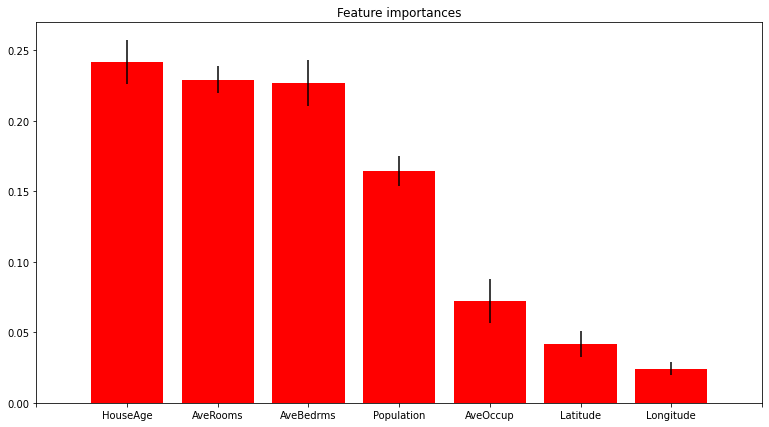

In [60]:
# get the estimates of feature importances
importances = model.feature_importances_
# calculate the std:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# This part will be used to make nice x-axis labels
# (we'll tell matplotlib to convert numeric feature
# index to a text label):
from matplotlib.ticker import FuncFormatter, MaxNLocator
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(len(importances)):
        return data.columns[int(tick_val)]
    else:
        return ''

fig, ax = plt.subplots(figsize=(13,7))
ax.set_title("Feature importances")
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xlim([-1, len(importances)])
plt.show();

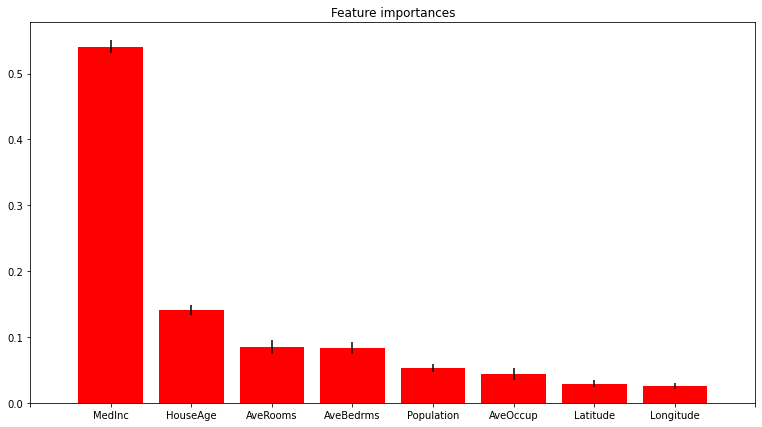

In [54]:
# get the estimates of feature importances
importances = model.feature_importances_
# calculate the std:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# This part will be used to make nice x-axis labels
# (we'll tell matplotlib to convert numeric feature
# index to a text label):
from matplotlib.ticker import FuncFormatter, MaxNLocator
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(len(importances)):
        return dataset.feature_names[int(tick_val)]
    else:
        return ''

fig, ax = plt.subplots(figsize=(13,7))
ax.set_title("Feature importances")
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xlim([-1, len(importances)])
plt.show();

## Bonus part: visualizing a tree

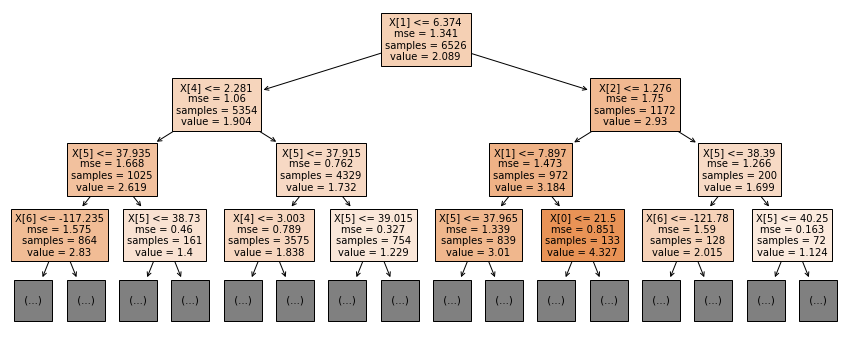

In [61]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 6))
plot_tree(model.estimators_[0], max_depth=3, fontsize=10, filled=True);

## Bonus part (2): Genetic hyperparameter search: TPOT

There's a nice tool called [TPOT](https://github.com/EpistasisLab/tpot) that applies genetic algorithms to search for an optimal pipeline and hyperparameter values.

In [ ]:
!pip install tpot

Here's a brief example of using TPOT:

In [ ]:
# import the model
from tpot import TPOTRegressor

# create an instance
tpot = TPOTRegressor(generations=2, population_size=5, verbosity=3)

# run the search:
tpot.fit(X_train.values, y_train.values)

# print the scoe:
print(tpot.score(X_test.values, y_test.values))

# export the optimal pipeline as a python script
tpot.export('tpot_california_pipeline.py')

Let's have a look at the optimal model we've found:

In [ ]:
with open('tpot_california_pipeline.py') as f:
  print(''.join(f.readlines()))

There's many other hyperparameter optimization methods, many implemented in the [scikit-optimize](https://scikit-optimize.github.io/) package, e.g. bayessian optimization with gaussian process ([see this link](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html) for a nice tutorial).

```
```
```
```